In [10]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import pandas as pd

In [11]:
plt.rc('figure', figsize=(12, 8))

In [12]:
img1_path = r'data/fusion/743.tiff'
img2_path = r'data/fusion/spot.tiff'

In [13]:
img1 = imageio.imread(img1_path)
img2 = imageio.imread(img2_path)
img1.shape, img2.shape

((4201, 4101, 3), (4201, 4101))

# Ratio

In [14]:
# convert uint8 to int for computation
D = img2.astype(int)
B1 = img1[..., 0].astype(int)
B2 = img1[..., 1].astype(int)
B3 = img1[..., 2].astype(int)

In [15]:
B123 = B1 + B2 + B3

DB1 = (B1 / B123) * D
DB2 = (B2 / B123) * D  
DB3 = (B3 / B123) * D

DB = np.stack([DB1, DB2, DB3], axis=2)

cond = np.where(B123 == 0)
DB[cond] = img1[cond].astype(int)
out_img1 = DB.astype('uint8')

C:\Users\26588\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\26588\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\26588\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


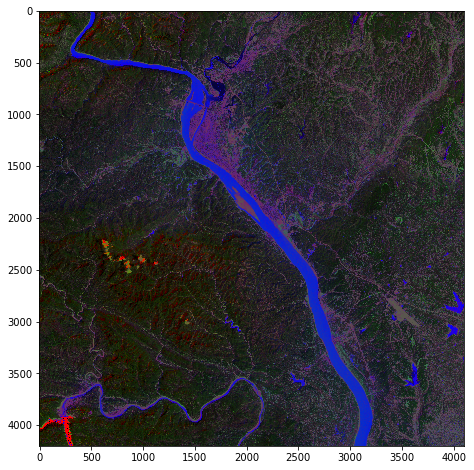

In [16]:
plt.imshow(out_img1)
plt.imsave(r'output/fusion/fusion_ratio.jpg', out_img1)

# Multiply Transform

In [17]:
DB1 = D * B1
DB2 = D * B2
DB3 = D * B3
DB = np.stack([DB1, DB2, DB3], axis=2)

In [18]:
out_img2 = (DB / DB.max() * 255).astype('uint8')

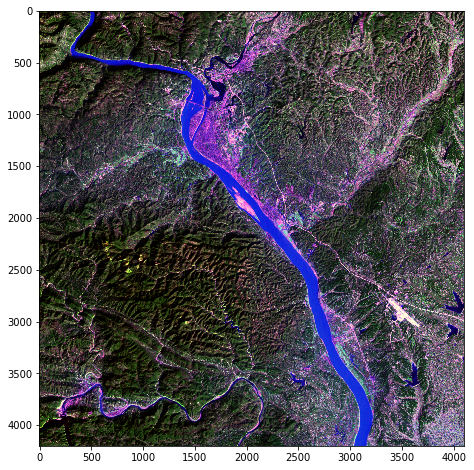

In [19]:
plt.imshow(out_img2)
plt.imsave('output/fusion/fusion_mul.jpg', out_img2)

# Weighted

In [20]:
r7 = np.corrcoef(B1.flatten(), D.flatten())[0][1]
r4 = np.corrcoef(B2.flatten(), D.flatten())[0][1]
r3 = np.corrcoef(B3.flatten(), D.flatten())[0][1]

In [21]:
print(r7, r4, r3, sep='\n')

0.21439147318879134
0.013059433617267928
0.6208717273365545


In [22]:
G1 = 0.5 * ((1 + abs(r7)) * D + (1 - abs(r7)) * B1)
G2 = 0.5 * ((1 + abs(r4)) * D + (1 - abs(r4)) * B2)
G3 = 0.5 * ((1 + abs(r3)) * D + (1 - abs(r3)) * B3)
out_img3 = np.stack([G1, G2, G3], axis=2).astype('uint8')

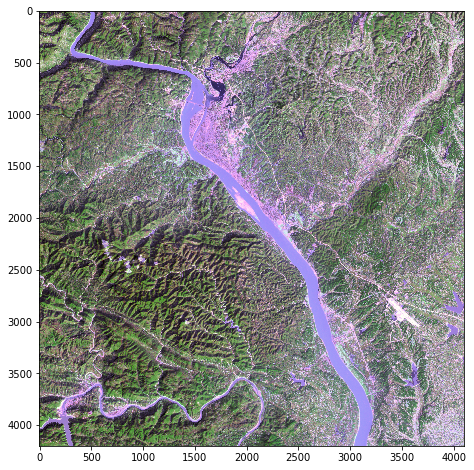

In [24]:
plt.imshow(out_img3)
plt.imsave('output/fusion/fusion_weighted.jpg', out_img3)

# Evaluation

In [25]:
images = [img1, out_img1, out_img2, out_img3]
names = ['initial', 'ratio', 'multiply', 'weighted']

In [26]:
def mean_gradient(img):
    img = img.astype(int)
    dx = img[1:, 1:] - img[1:, :-1]    
    dy = img[1:, 1:] - img[:-1, 1:]
    w, h = img.shape[:2]
    mean_g = np.sum(np.hypot(dx, dy), axis=(0, 1)) / w / h
    return mean_g

In [27]:
def hist(img):
    p = np.histogram(img.astype('uint8'), 256, density=True)[0]
    return p

def colored_entropy(img):
    pi = hist(img[..., 0])
    pj = hist(img[..., 1])
    pk = hist(img[..., 2])

    pi, pj, pk = np.meshgrid(pi, pj, pk)
    pijk = pi * pj * pk
    
    p = pijk.flatten()
    p = p[np.where(p != 0)]
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [28]:
info = []
for img, name in zip(images, names):
    ent = colored_entropy(img)
    gradient = mean_gradient(img)
    info.append([ent, *gradient])    

In [29]:
cols = ['Entropy', 'Gradient_R', 'Gradient_G', 'Gradient_B']
df = pd.DataFrame(info, index=names, columns=cols)    
df

,Entropy,Gradient_R,Gradient_G,Gradient_B
initial,25.078150,13.615380,13.164610,9.099757
ratio,19.020265,7.399477,6.917236,7.266347
multiply,25.245605,13.175253,12.392127,11.768125
weighted,23.450328,13.239320,12.260937,15.297265


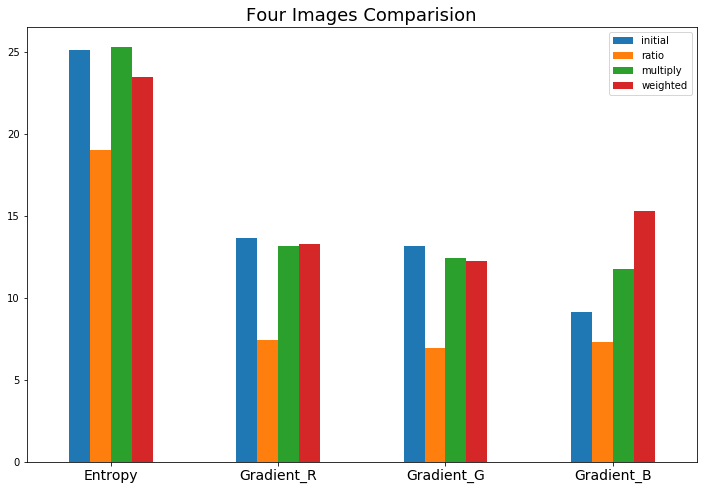

In [32]:
df.T.plot(kind='bar', )
plt.xticks(rotation=0, size=14)
plt.title('Four Images Comparision', size=18)
plt.savefig('output/fusion/comparison.jpg')